In [1]:
pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import os
from fastai.vision.all import *
from nbdev.showdoc import *
import fastbook
fastbook.setup_book()
import random
from fastai.vision.augment import aug_transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from fastai.data.load import DataLoader
from imblearn.over_sampling import RandomOverSampler


2024-06-02 18:27:47.122343: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 18:27:47.181458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 18:27:48.261737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
class RocAuc(Metric):
    def __init__(self): self._name = "roc_auc_score"
    def reset(self): self.preds, self.targets = [], []
    def accumulate(self, learn):
        preds = learn.pred.argmax(dim=-1).cpu().numpy()
        targets = learn.y.cpu().numpy()
        self.preds.extend(preds)
        self.targets.extend(targets)
    @property
    def value(self):
        if len(np.unique(self.targets)) == 1:
            return 0.0  # if only one class in targets, roc_auc_score can't be calculated
        return roc_auc_score(self.targets, self.preds)
    @property
    def name(self):
        return self._name
    
def get_weights(dls):
    classes = dls.vocab
    train_lbls = L(map(lambda x: classes[x[1]], dls.train_ds))
    label_counter = Counter(train_lbls)
    n_most_common_class = max(label_counter.values())
    print(f'Occurrences of the most common class {n_most_common_class}')
    weights = [n_most_common_class/v for k, v in label_counter.items() if v > 0]
    return weights

In [4]:
bac_minus_folder = 'NEGATIVOS'
bac_plus_folder = 'POSITIVOS'

bac_minus_paths = get_image_files(bac_minus_folder)
bac_plus_paths = get_image_files(bac_plus_folder)

bac_minus_labels = [0] * len(bac_minus_paths)
bac_plus_labels = [1] * len(bac_plus_paths)

all_paths = bac_minus_paths + bac_plus_paths
all_labels = bac_minus_labels + bac_plus_labels

df = pd.DataFrame({'image_path': all_paths, 'label': all_labels})

ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
oversampled_paths, oversampled_labels = ros.fit_resample(df[['image_path']], df['label'])

oversampled_df = pd.DataFrame({'image_path': oversampled_paths['image_path'], 'label': oversampled_labels})

train_df, valid_df = train_test_split(oversampled_df, test_size=0.2, random_state=42, stratify=oversampled_df['label'])

assert len(train_df['label'].unique()) > 1, "El conjunto de entrenamiento no tiene más de una clase"
assert len(valid_df['label'].unique()) > 1, "El conjunto de validación no tiene más de una clase"

print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    splitter=ColSplitter(col='is_valid'),
    item_tfms=Resize(512),
    batch_tfms=aug_transforms(flip_vert=False, do_flip=False)
)

train_df['is_valid'] = False
valid_df['is_valid'] = True
combined_df = pd.concat([train_df, valid_df])

dls = dblock.dataloaders(combined_df)

1    3534
0    3533
Name: label, dtype: int64
0    884
1    883
Name: label, dtype: int64


In [5]:
vis_learn = cnn_learner(dls, resnet18, metrics=[accuracy, RocAuc()], pretrained=True)

/data/home/alopezortiz/fastai-master/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [6]:
vis_learn.fine_tune(15, freeze_epochs=15, 
                      cbs=[EarlyStoppingCallback(monitor='accuracy', patience=10), 
                           SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_VIS_oversampled')])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.812281,0.588295,0.790040,0.790136,07:23
1,0.676215,0.487732,0.806452,0.806536,07:20
2,0.637162,0.454064,0.817770,0.817846,07:16
3,0.563521,0.443088,0.819468,0.819559,07:11
4,0.515437,0.381127,0.830787,0.830853,07:07
5,0.462793,0.372387,0.834748,0.834822,07:10
6,0.426259,0.370608,0.825693,0.825778,07:14
7,0.411773,0.341222,0.844369,0.844436,07:16
8,0.396491,0.361819,0.839276,0.839361,08:09
9,0.383900,0.326495,0.851160,0.851228,07:54


Better model found at epoch 0 with accuracy value: 0.790039598941803.
Better model found at epoch 1 with accuracy value: 0.8064516186714172.
Better model found at epoch 2 with accuracy value: 0.81777024269104.
Better model found at epoch 3 with accuracy value: 0.8194680213928223.
Better model found at epoch 4 with accuracy value: 0.8307866454124451.
Better model found at epoch 5 with accuracy value: 0.8347481489181519.
Better model found at epoch 7 with accuracy value: 0.8443689942359924.
Better model found at epoch 9 with accuracy value: 0.8511601686477661.
Better model found at epoch 11 with accuracy value: 0.8562535643577576.
Better model found at epoch 12 with accuracy value: 0.8585172891616821.
Better model found at epoch 14 with accuracy value: 0.8732314705848694.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.296790,0.247350,0.893605,0.893645,07:51
1,0.259317,0.309860,0.876061,0.876105,08:05
2,0.240402,0.230596,0.902660,0.902657,08:07
3,0.215527,0.180446,0.940577,0.940605,07:51
4,0.178077,0.158399,0.933786,0.933767,07:57
5,0.141414,0.120285,0.950764,0.950771,07:51
6,0.122749,0.106313,0.968874,0.968888,08:13
7,0.076262,0.102983,0.958687,0.958692,07:53
8,0.055173,0.078052,0.970572,0.970570,07:57
9,0.043900,0.063131,0.979626,0.979638,08:30


Better model found at epoch 0 with accuracy value: 0.8936049938201904.
Better model found at epoch 2 with accuracy value: 0.9026598930358887.
Better model found at epoch 3 with accuracy value: 0.9405772686004639.
Better model found at epoch 5 with accuracy value: 0.950764000415802.
Better model found at epoch 6 with accuracy value: 0.9688737988471985.
Better model found at epoch 8 with accuracy value: 0.9705715775489807.
Better model found at epoch 9 with accuracy value: 0.979626476764679.


In [7]:
vis_learn.export('fastai2_VIS_oversampled.pkl')

In [8]:
pip install cPickle

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement cPickle (from versions: none)
ERROR: No matching distribution found for cPickle
Note: you may need to restart the kernel to use updated packages.


In [9]:
from cPickle import Pickler, Unpickler, UnpicklingError

class FilteredObject:
    def __init__(self, about):
        self.about = about
    def __repr__(self):
        return 'FilteredObject(%s)' % repr(self.about)

class MyPickler(object):
    def __init__(self, file, protocol=2):
        pickler = Pickler(file, protocol)
        pickler.persistent_id = self.persistent_id
        self.dump = pickler.dump
        self.clear_memo = pickler.clear_memo

    def persistent_id(self, obj):
           if not hasattr(obj, '__getstate__') and not isinstance(obj,
        (basestring, bool, int, long, float, complex, tuple, list, set, dict)):
            return ["filtered:%s" % str(obj)]
           else:
            return None

class MyUnpickler(object):
    def __init__(self, file):
        unpickler = Unpickler(file)
        unpickler.persistent_load = self.persistent_load
        self.load = unpickler.load
        self.noload = unpickler.noload

    def persistent_load(self, obj_id):
        if obj_id[0].startswith('filtered:'):
            return FilteredObject(obj_id[0][9:])
        else:
            raise UnpicklingError('Invalid persistent id')

###### serialize to file

#f = open('fastai2_VIS_oversampled.pkl','wb')
#p = MyPickler(f)
#p.dump(data)
#f.close()

###### unserialize from file

f = open('fastai2_VIS_oversampled.pkl','rb')
pickled_data = f.read()
f.seek(0)
u = MyUnpickler(f)
data = u.load()    

ModuleNotFoundError: No module named 'cPickle'

In [4]:
model_path = 'fastai2_VIS_oversampled.pkl'

vis_learn = load_learner(model_path)

UnpicklingError: NEWOBJ class argument must be a type, not function

In [9]:
train_losses = [x[0] for x in vis_learn.recorder.values]
valid_losses = [x[1] for x in vis_learn.recorder.values]
accuracies = [x[2] for x in vis_learn.recorder.values]
roc_auc_scores = [x[3] for x in vis_learn.recorder.values]




In [14]:
def frange(start, stop, step):
    while start < stop:
        yield start
        start += step

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que train_losses, valid_losses, accuracies y roc_auc_scores ya están definidos
epochs = range(1, len(train_losses) + 1)

# Definir el intervalo de los ticks en los ejes y los límites
y_tick_interval = 0.0000001
x_tick_interval = 1

# Gráfico de Loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_losses, 'r', label='Train Loss')
plt.plot(epochs, valid_losses, 'b', label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(1, len(epochs) + 1, x_tick_interval))
plt.yticks(np.arange(min(train_losses + valid_losses), max(train_losses + valid_losses) + y_tick_interval, y_tick_interval))
plt.ylim(min(train_losses + valid_losses), max(train_losses + valid_losses))
plt.show()

# Gráfico de Accuracy y ROC AUC
plt.figure(figsize=(12, 5))
plt.plot(epochs, accuracies, 'g', label='Accuracy')
plt.plot(epochs, roc_auc_scores, 'm', label='ROC AUC')
plt.title('Accuracy and ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.xticks(range(1, len(epochs) + 1, x_tick_interval))
plt.yticks(np.arange(min(accuracies + roc_auc_scores), max(accuracies + roc_auc_scores) + y_tick_interval, y_tick_interval))
plt.ylim(min(accuracies + roc_auc_scores), max(accuracies + roc_auc_scores))
plt.show()


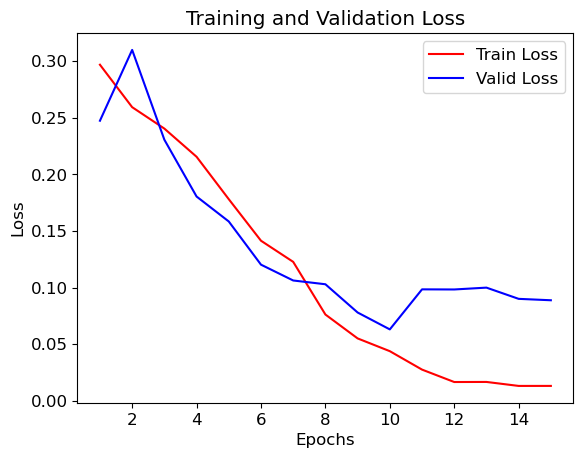

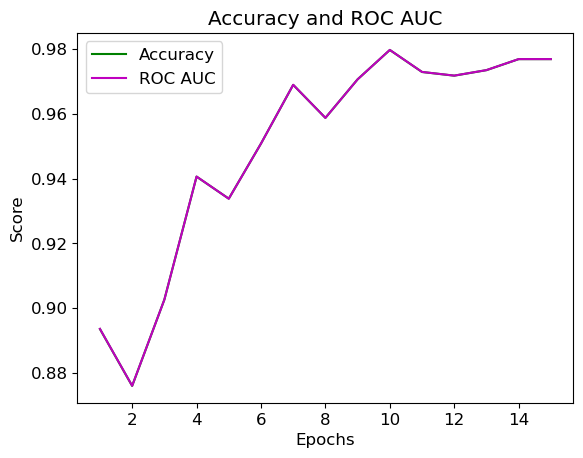

In [10]:
epochs = range(1, len(train_losses) + 1)



plt.plot(epochs, train_losses, 'r', label='Train Loss')
plt.plot(epochs, valid_losses, 'b', label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracies, 'g', label='Accuracy')
plt.plot(epochs, roc_auc_scores, 'm', label='ROC AUC')
plt.title('Accuracy and ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.show()

Predictions shape: torch.Size([1767, 2])
Targets shape: torch.Size([1767])
Adjusted Targets shape: torch.Size([1767])
Confusion Matrix:
[[848  36]
 [  0 883]]


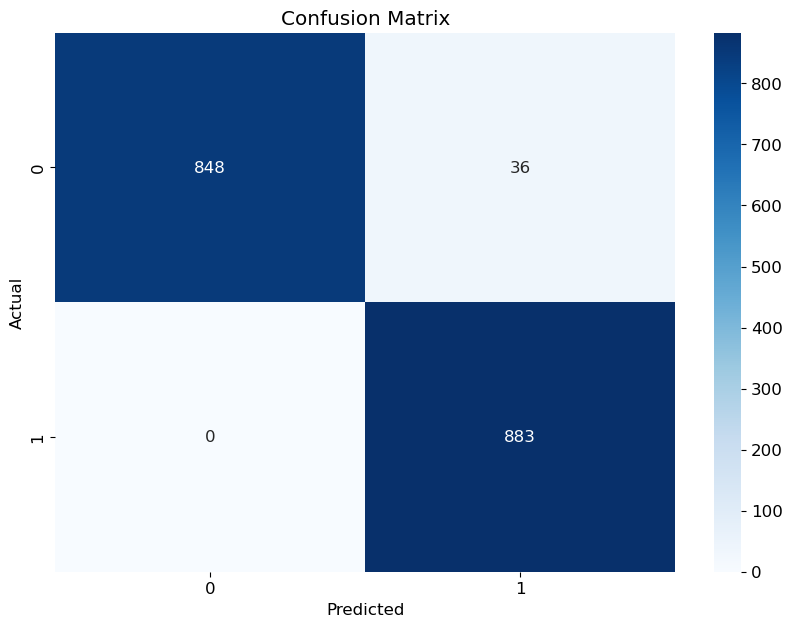

In [11]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

preds, targs = vis_learn.get_preds()
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')
if len(targs.shape) > 1 and targs.shape[1] == 1:
    targs = targs.squeeze(1)
print(f'Adjusted Targets shape: {targs.shape}')
cm = confusion_matrix(targs, preds.argmax(dim=1))
print('Confusion Matrix:')
print(cm)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dls.vocab, yticklabels=dls.vocab)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

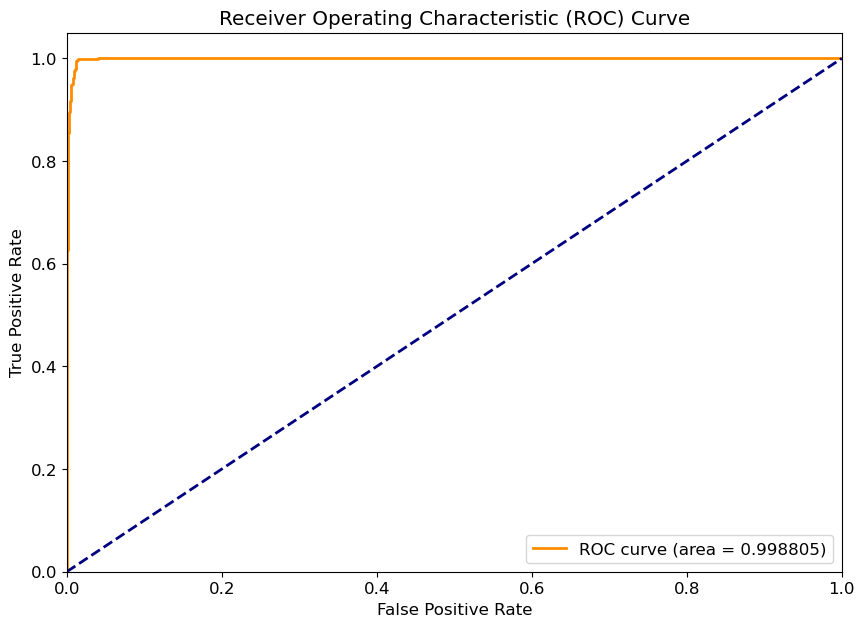

In [12]:
from sklearn.metrics import roc_curve, auc

preds, targs = vis_learn.get_preds()
probs = preds[:, 1]
fpr, tpr, _ = roc_curve(targs, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()